# Taller Semana 3 - Análisis de entrada

Integrantes:
- Oscar Camilo Álvarez Torres
- Maria Camila Lenis Restrepo

## Introducción

Para el presente informe vamos a análizar la información que se nos provee acerca de llegadas de aviones, características de clientes y datos del servicio biométrico del Aeropuerto Internacional El Morado. Esto con el fin de caracterizar el comportamiento del sistema usando distribuciones, y de esta manera modelar el sistema de forma correcta.

Comenzamos importando las librerías necesarias y declarando una variable para la ruta del archivo de datos:

In [1]:
import numpy as np
import pandas as pd
from funciones_qq_pp_plot import *
from funcioneschicuadrado_continuas import*
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

archivo_excel = 'Datos-Caso-III.xlsx'

## Distribución del tiempo entre arribos

Se nos ha sugerido utilizar las siguientes franjas horarias para los tiempos entre arribos de aviones desde un destino internacional:

- 6:00 am – 11:00 am
- 11:00 am – 3:00 pm
- 3:00 pm – 9:00 pm
- 9:00 pm – 6:00 am

Entre estas franjas se van a ubicar los distintos datos y luego se utilizará algúna prueba de bondad de ajuste para validar al distribución de los datos y así caracterizar el comportamiento entre arribos de una franja u otra.

### Lectura de datos

En el siguiente código se hace lectura de los datos en la hoja de DatosLlegadaAviones y se procede a ubicar cada uno de los datos en alguna de las franjas horarias.

Por último se da una mirada inicial al dataframe para ver un resumen de cómo lucen los datos.

In [2]:
# Cargar el archivo de Excel
datos_llegada_aviones = pd.read_excel(archivo_excel, sheet_name='DatosLlegadaAviones')

# Convertir la columna 'Fecha de Llegada' a formato datetime
datos_llegada_aviones['Fecha de Llegada'] = pd.to_datetime(datos_llegada_aviones['Fecha de Llegada'], format='%d/%m/%Y %H:%M:%S')

# Agregar una columna de 'Día' para agrupar
datos_llegada_aviones['Día'] = datos_llegada_aviones['Fecha de Llegada'].dt.date

# Definir las franjas horarias
franjas_horarias = {
    'Franja_1': ('06:00:00', '11:00:00'),
    'Franja_2': ('11:00:00', '15:00:00'),
    'Franja_3': ('15:00:00', '21:00:00'),
    'Franja_4': ('21:00:00', '06:00:00')
}

def calcular_tiempo_entre_arribos(df, franja):
    inicio, fin = franja

    # Convertir inicio y fin a tiempo
    inicio = datetime.strptime(inicio, '%H:%M:%S').time()
    fin = datetime.strptime(fin, '%H:%M:%S').time()

    # Filtrar los datos según la franja horaria
    if inicio < fin:
        df_franja = df[(df['Fecha de Llegada'].dt.time >= inicio) & (df['Fecha de Llegada'].dt.time < fin)].copy()
    else:  # Para la franja que cruza la medianoche
        df_franja_temprano = df[df['Fecha de Llegada'].dt.time >= inicio].copy()
        df_franja_tarde = df[df['Fecha de Llegada'].dt.time < fin].copy()

        # Ajustar la fecha para los datos que caen después de medianoche
        df_franja_tarde.loc[:, 'Fecha de Llegada Ajustada'] = df_franja_tarde['Fecha de Llegada'] + timedelta(days=1)
        df_franja_tarde.sort_values(by='Fecha de Llegada Ajustada', inplace=True)

        # Ordenar datos antes de medianoche
        df_franja_temprano.sort_values(by='Fecha de Llegada', inplace=True)

        # Concatenar los datos ajustados y no ajustados
        df_franja = pd.concat([df_franja_tarde, df_franja_temprano])
        df_franja.sort_values(by=['Día', 'Fecha de Llegada'], inplace=True)

    # Calcular diferencias de tiempo entre arribos consecutivos dentro del mismo día
    df_franja.loc[:, 'Fecha de Llegada Ajustada'] = df_franja.get('Fecha de Llegada Ajustada', df_franja['Fecha de Llegada'])
    tiempos_entre_arribos = df_franja.groupby('Día')['Fecha de Llegada Ajustada'].diff().dropna()
    tiempos_entre_arribos_segundos = tiempos_entre_arribos.dt.total_seconds()

    return df_franja, tiempos_entre_arribos_segundos

# Aplicar la función a cada franja horaria y compilar los resultados
resultados = {}

for franja, horas in franjas_horarias.items():
    df_franja, tiempos = calcular_tiempo_entre_arribos(datos_llegada_aviones, horas)
    resultados[franja] = tiempos

datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión,Día
0,2023-05-01 00:00:00.000,Mediano,2023-05-01
1,2023-05-01 00:12:48.533,Grande,2023-05-01
2,2023-05-01 00:20:31.919,Mediano,2023-05-01
3,2023-05-01 00:31:48.641,Pequeño,2023-05-01
4,2023-05-01 00:40:09.796,Pequeño,2023-05-01


### Distribuciones según histogramas

En la siguiente parte, se van a realizar histogramas para cada una de las franjas y así tener una primera idea de su distribución. Cabe resaltar que no es un método matemático formal o exacto, es una aproximación un tanto subjetiva. Por ende, en puntos siguientes vamos a utilizar alguna técnica de bondad de ajuste.

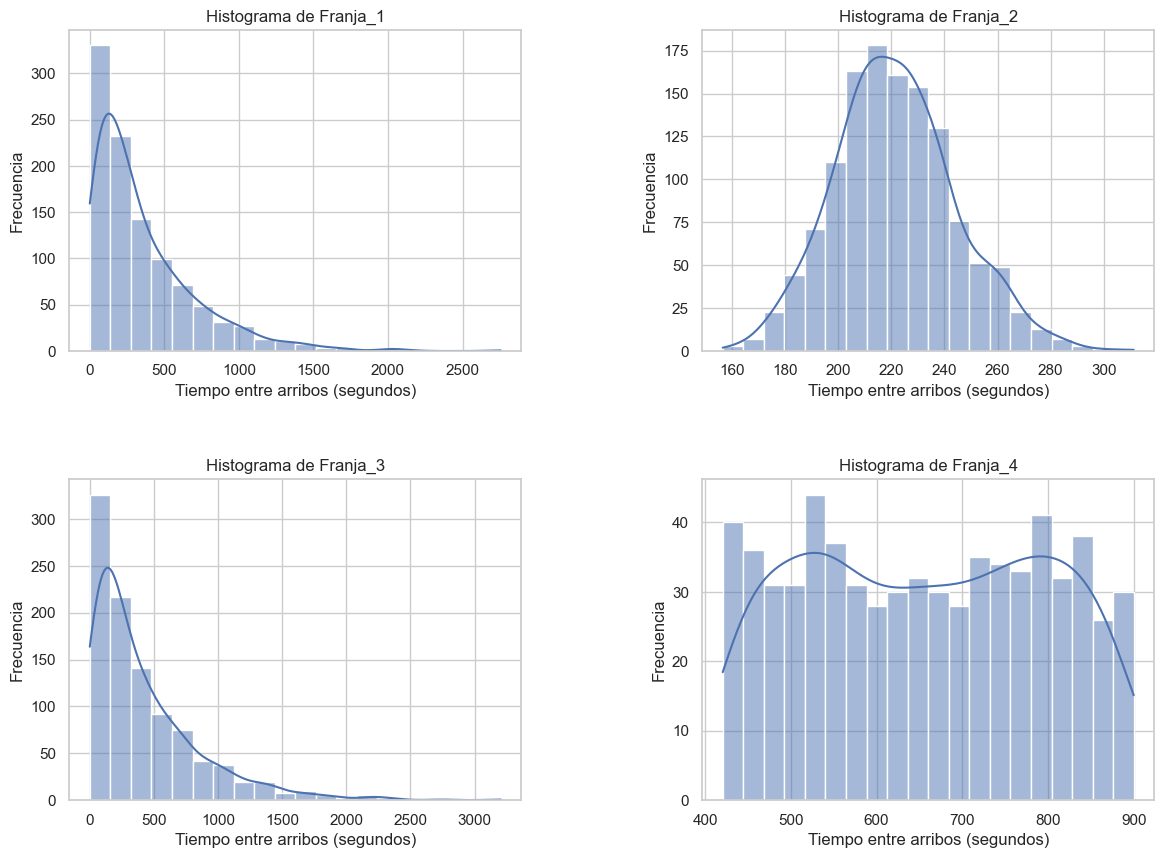

In [3]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura y ejes para los histogramas
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Crear una grilla 2x2

# Ajustar la grilla con un espaciado adecuado
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Iterar sobre las franjas y graficar los histogramas en los ejes correspondientes
for ax, (franja, tiempos) in zip(axs.flatten(), resultados.items()):
    sns.histplot(tiempos, bins=20, kde=True, ax=ax)
    ax.set_title(f'Histograma de {franja}')
    ax.set_xlabel('Tiempo entre arribos (segundos)')
    ax.set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.show()

#### Análisis

- La primera y tercera franja parecen tener una forma exponencial
- La segunda franja parece tener una distribución normal
- Para la franja 4 no se encuentra una distribución facilmente identificable. Podría ser uniforme. Se opta por usar un algún otro método para encontrarla.

### Gráficas Q-Q y P-P Plot para distribuciones continuas

#### Graficas por franja horaria

Se procede a generar gráficas Q-Q Plot y P-P Plot para las distintas franjas horarios utilizando las distribuciones siguientes:

*   Normal
*   Lognormal
*   Exponencial
*   Uniforme
*   Triangular
*   Gamma
*   Weibull

Además se imprimirán los parámetros estimados para cada una.

Esto se va a realizar de manera iterativa para generar todos los gráficos en una sola ejecución y se darán conclusiones al respecto.








	GRAFICAS PARA Franja_1

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Gráficas para una distribución normal

Parámetro estimado: Media = 356.9033648780488
Parámetro estimado: Desviación Estándar = 349.25628560960234


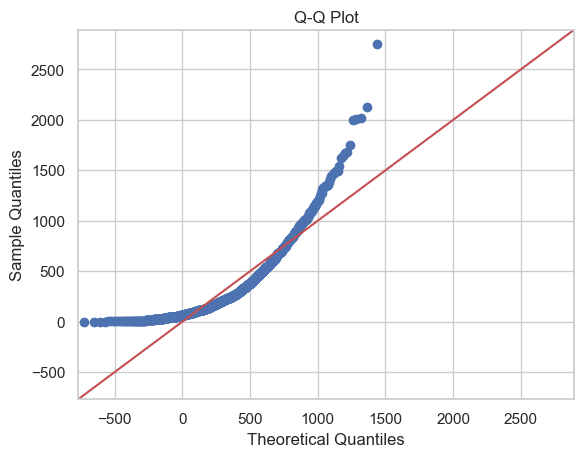

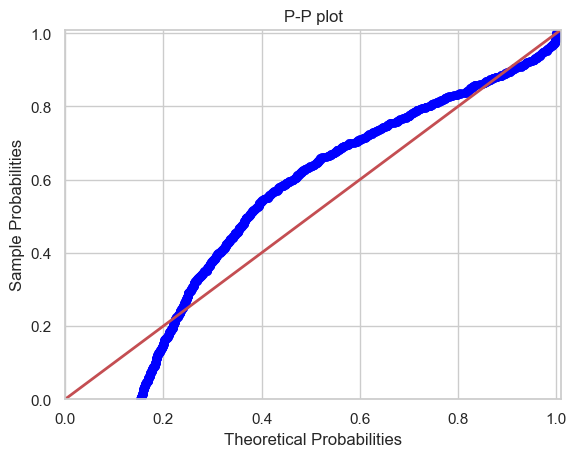


Gráficas para una distribución lognormal

Parámetro estimado (normal asociada): Media = 5.3225267637146585
Parámetro estimado (normal asociada): Desviación Estándar = 1.2498301729549852


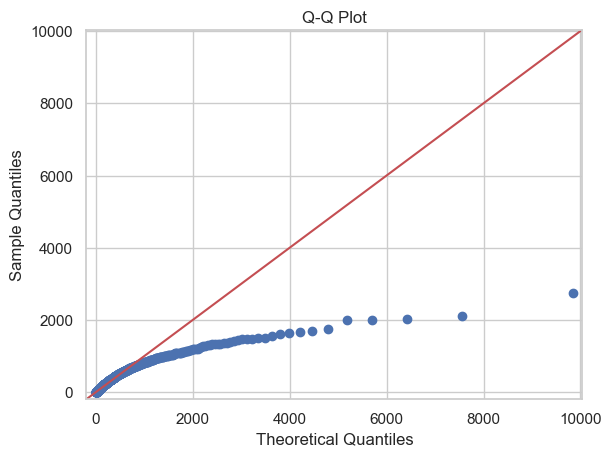

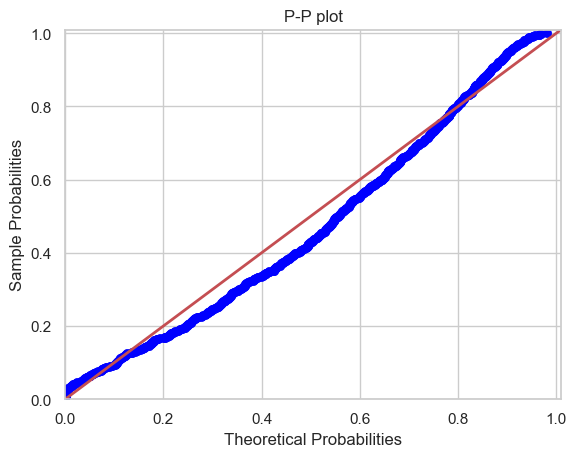


Gráficas para una distribución exponencial

Parámetro estimado: Tasa = 0.0028018788792918566


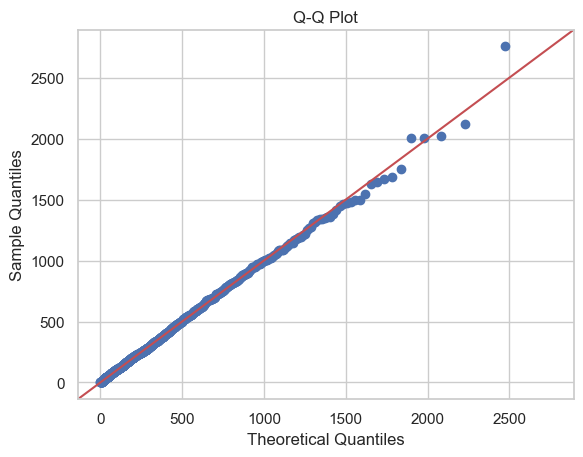

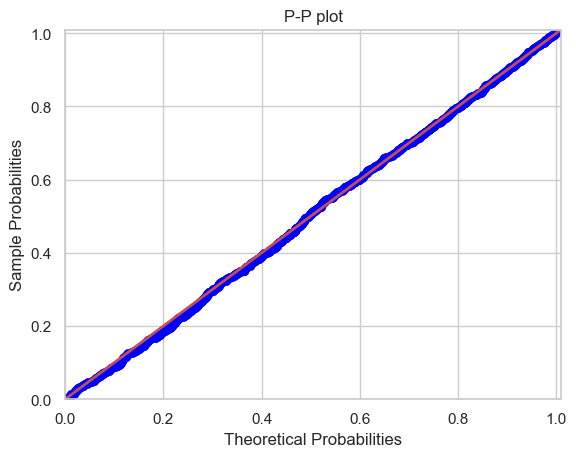


Gráficas para una distribución uniforme

Parámetro estimado: a = 0.213
Parámetro estimado: b = 2755.953


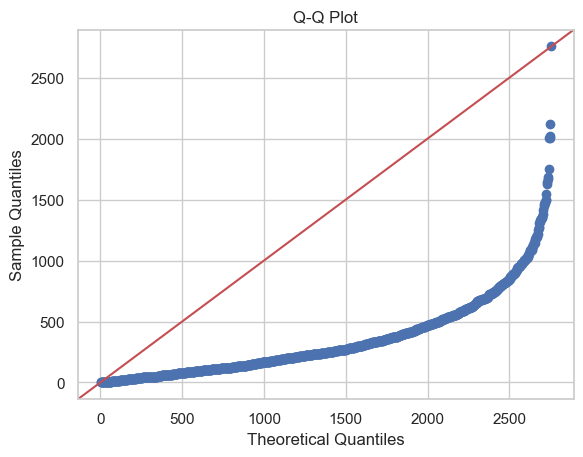

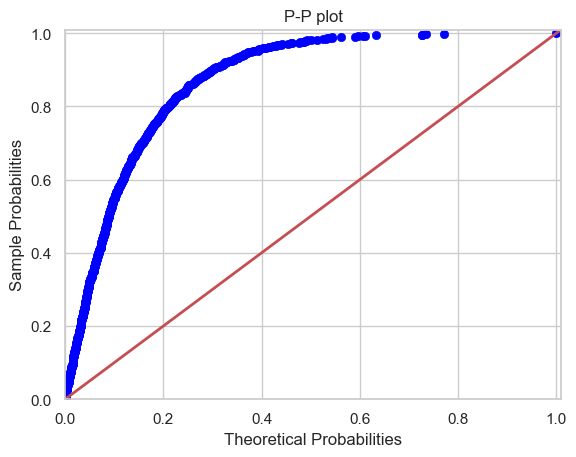


Gráficas para una distribución triangular

Parámetro estimado: a = 0.213
Parámetro estimado: b = 2755.953
Parámetro estimado: c = 119.347


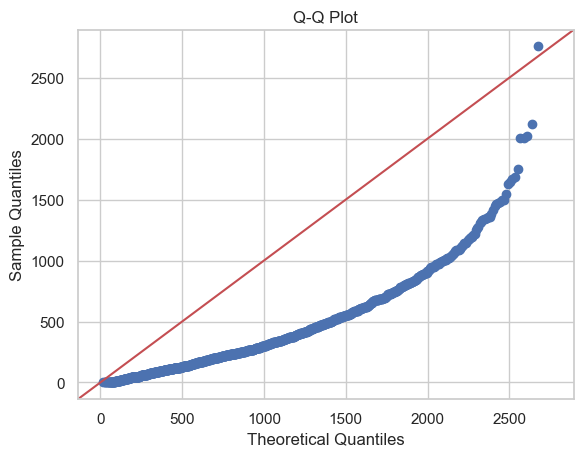

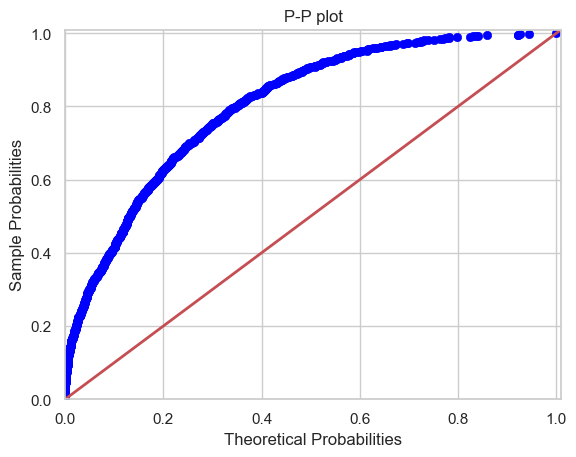


Gráficas para una distribución gamma

Parámetro estimado: Media = 356.9033648780488
Parámetro estimado: Varianza = 121979.95303781614


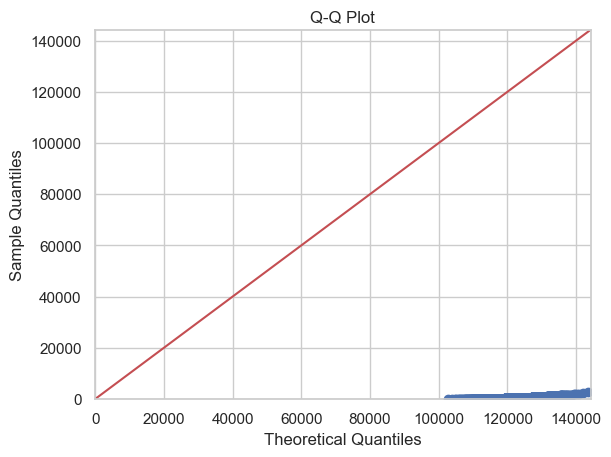

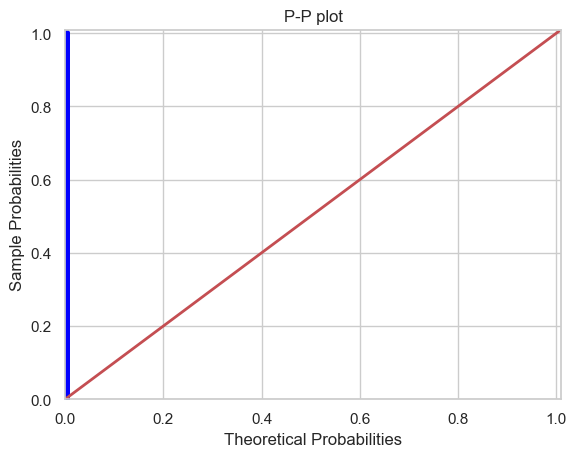


Gráficas para una distribución weibull

Parámetro estimado: Escala = 360.11129894444923
Parámetro estimado: Forma = 1.0219414569820682


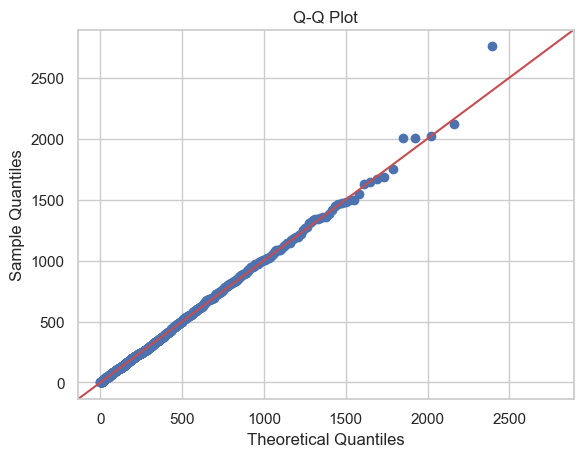

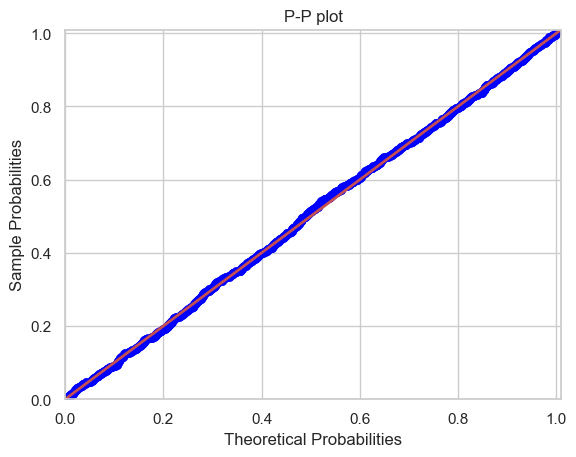


	GRAFICAS PARA Franja_2

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Gráficas para una distribución normal

Parámetro estimado: Media = 221.5082436908517
Parámetro estimado: Desviación Estándar = 22.929183141009595


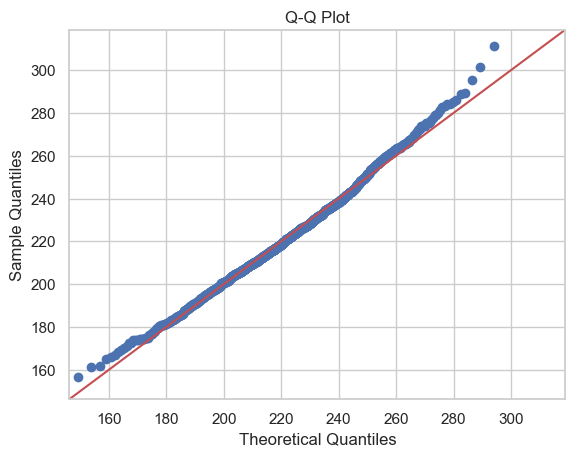

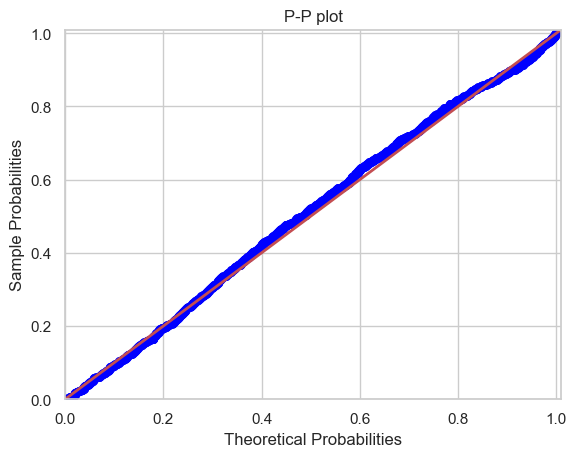


Gráficas para una distribución lognormal

Parámetro estimado (normal asociada): Media = 5.3951237339450016
Parámetro estimado (normal asociada): Desviación Estándar = 0.1033441222569458


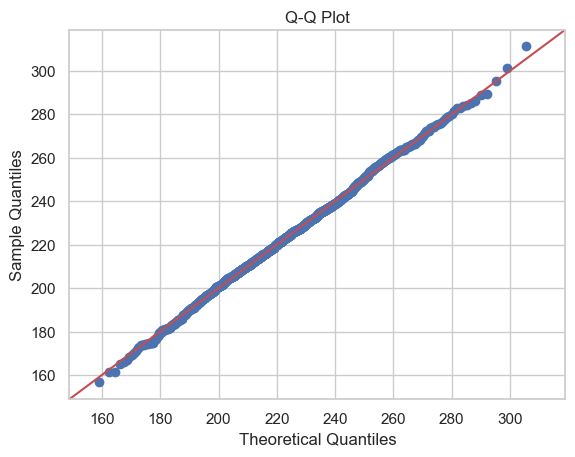

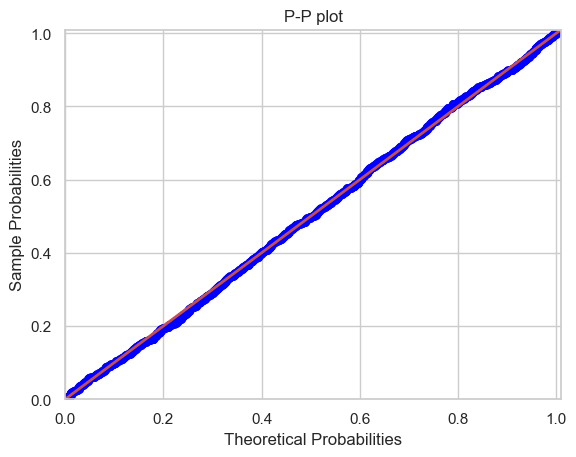


Gráficas para una distribución exponencial

Parámetro estimado: Tasa = 0.004514504667355186


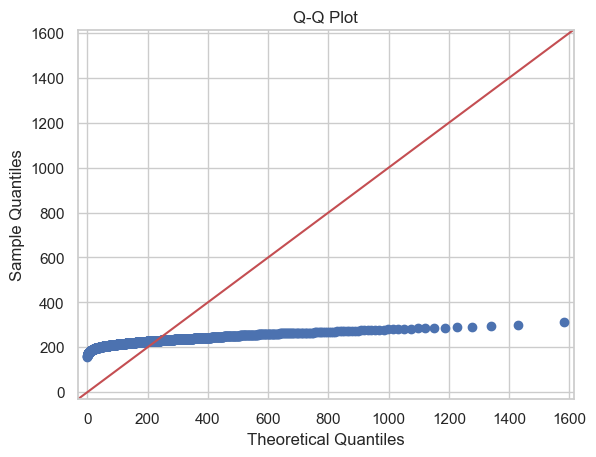

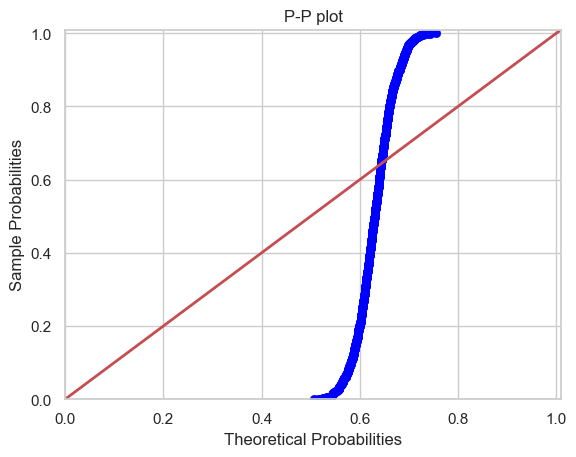


Gráficas para una distribución uniforme

Parámetro estimado: a = 156.561
Parámetro estimado: b = 311.217


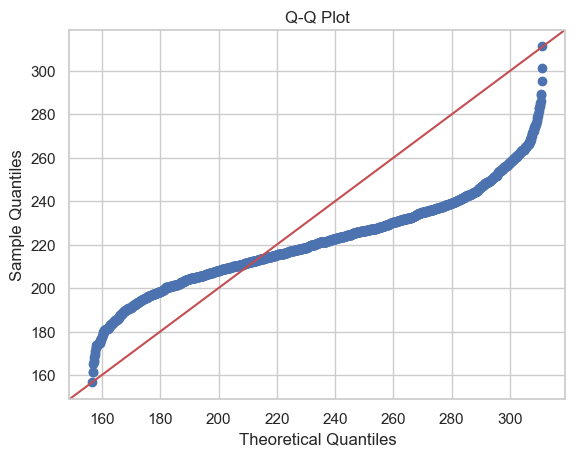

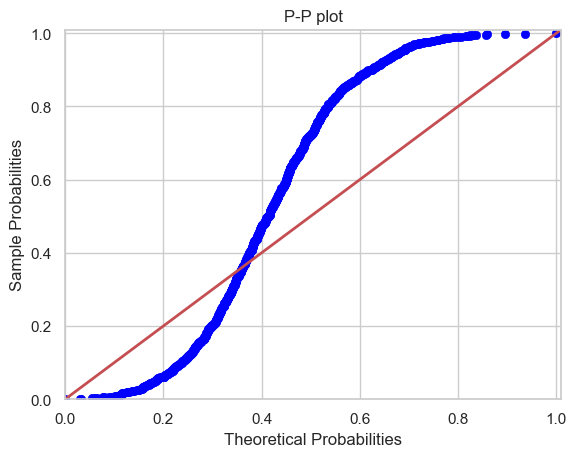


Gráficas para una distribución triangular

Parámetro estimado: a = 156.561
Parámetro estimado: b = 311.217
Parámetro estimado: c = 214.683


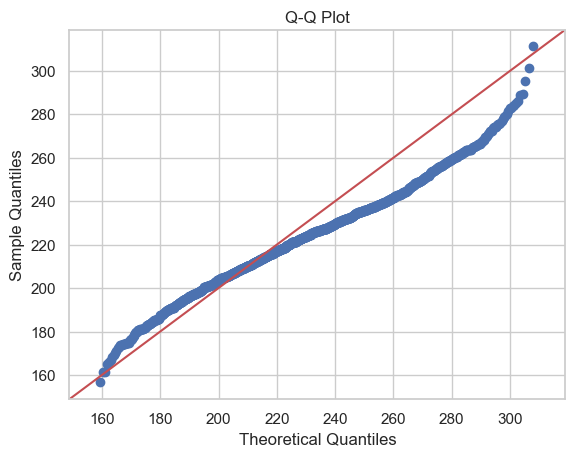

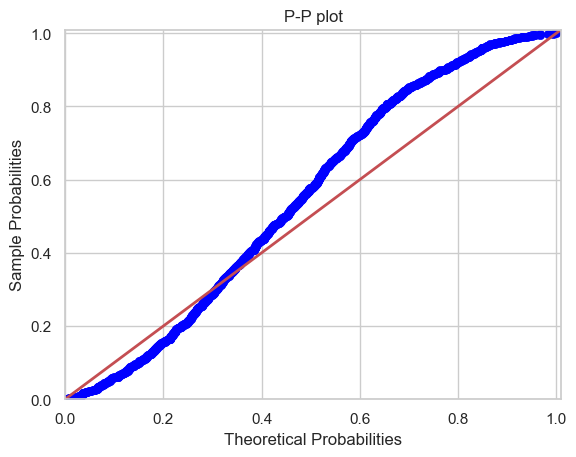


Gráficas para una distribución gamma

Parámetro estimado: Media = 221.5082436908517
Parámetro estimado: Varianza = 525.7474395139586


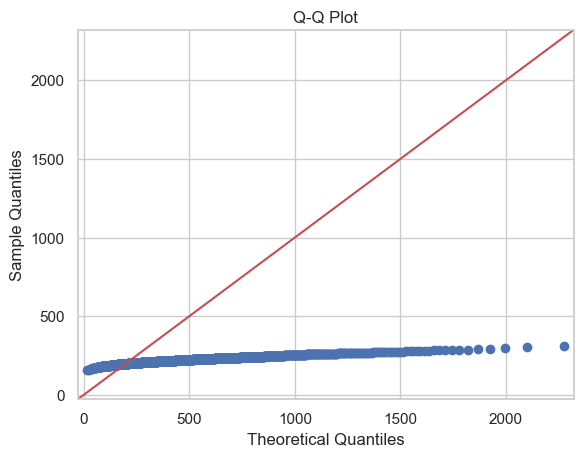

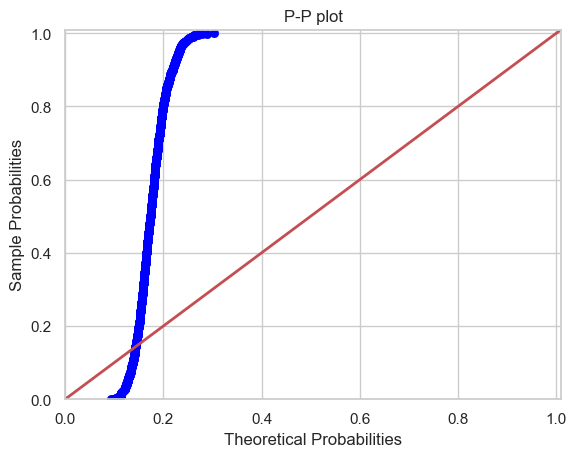


Gráficas para una distribución weibull

Parámetro estimado: Escala = 232.00428381887883
Parámetro estimado: Forma = 9.731316160251238


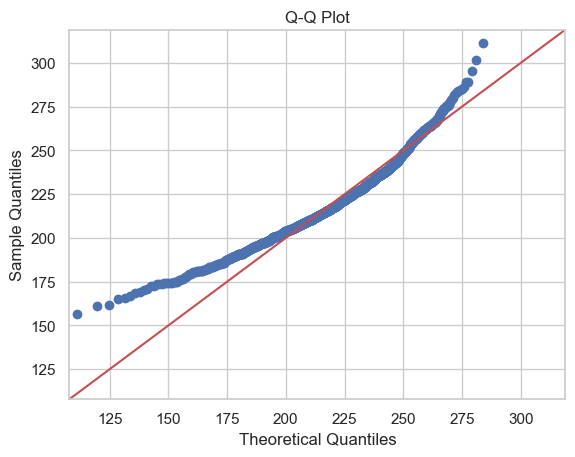

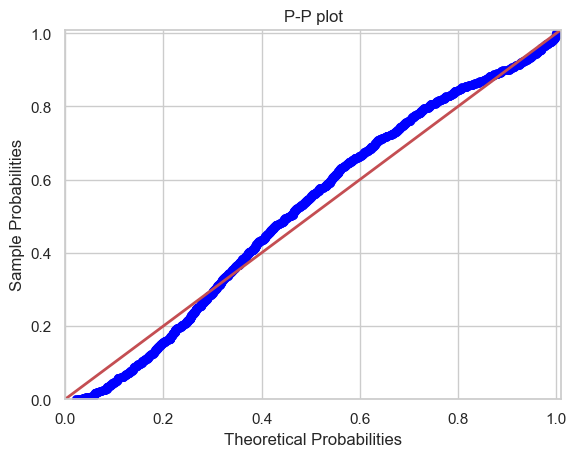


	GRAFICAS PARA Franja_3

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Gráficas para una distribución normal

Parámetro estimado: Media = 421.00287912087913
Parámetro estimado: Desviación Estándar = 427.80592767128843


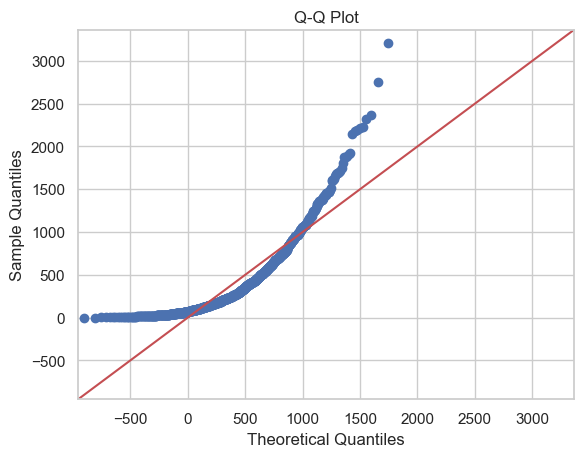

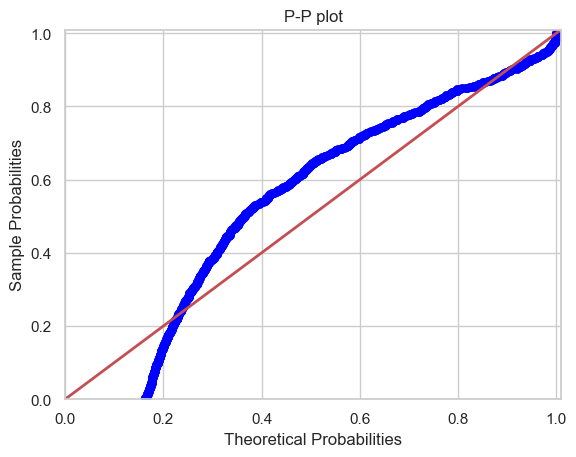


Gráficas para una distribución lognormal

Parámetro estimado (normal asociada): Media = 5.462529944373125
Parámetro estimado (normal asociada): Desviación Estándar = 1.2478932484049388


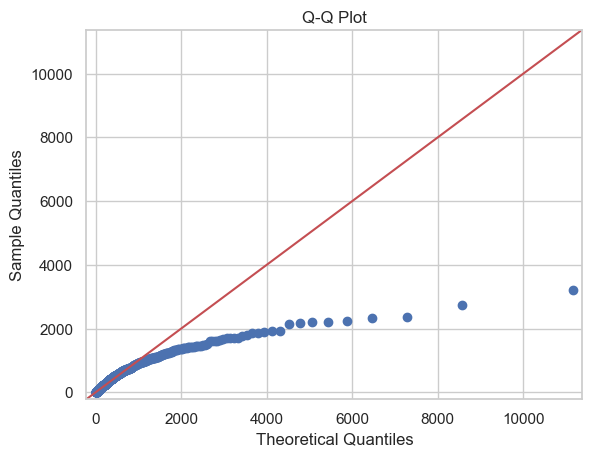

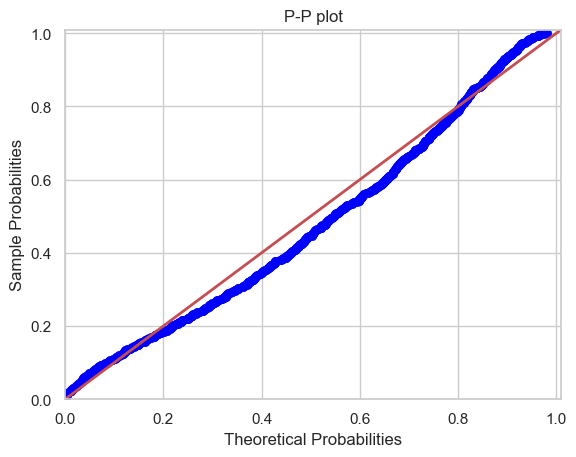


Gráficas para una distribución exponencial

Parámetro estimado: Tasa = 0.002375280668123123


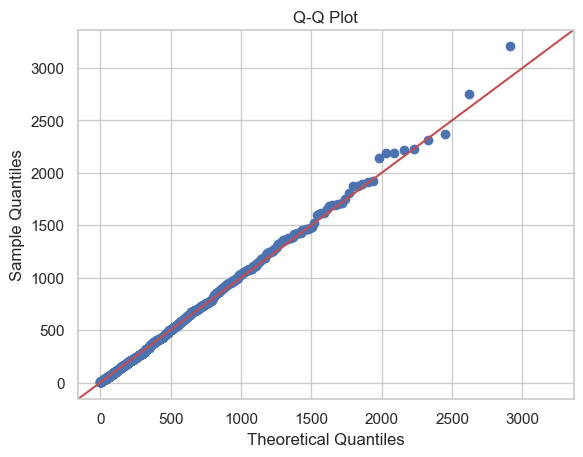

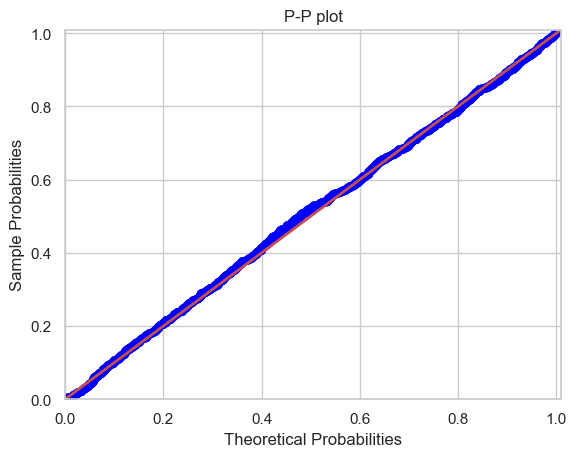


Gráficas para una distribución uniforme

Parámetro estimado: a = 1.069
Parámetro estimado: b = 3204.63


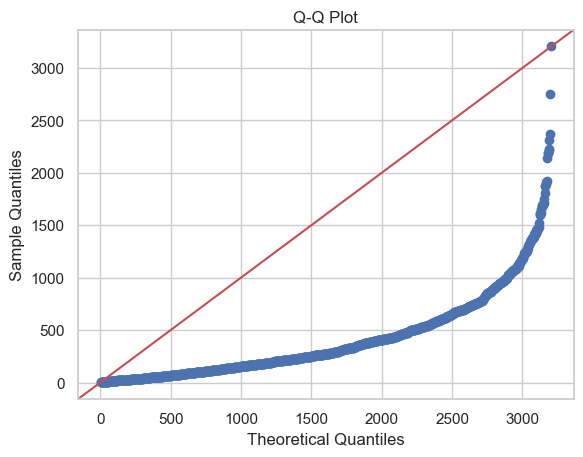

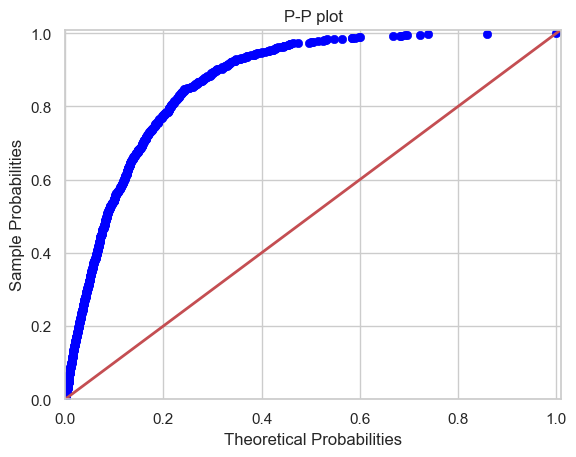


Gráficas para una distribución triangular

Parámetro estimado: a = 1.069
Parámetro estimado: b = 3204.63
Parámetro estimado: c = 269.152


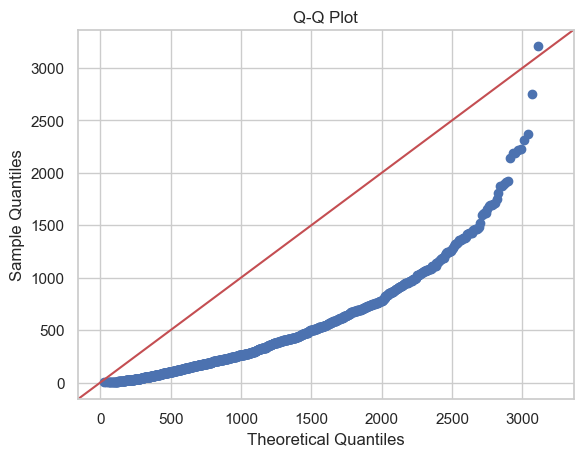

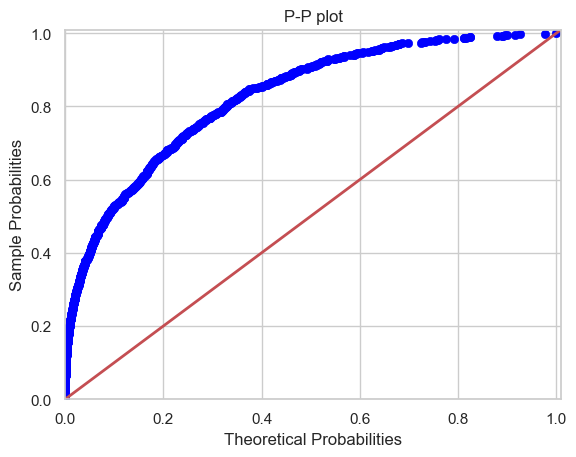


Gráficas para una distribución gamma

Parámetro estimado: Media = 421.00287912087913
Parámetro estimado: Varianza = 183017.91175069168


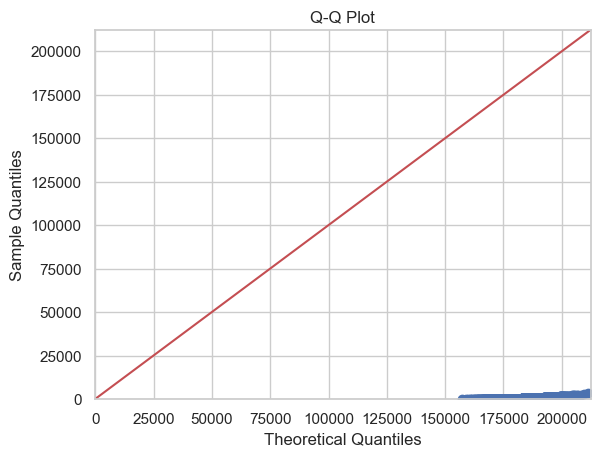

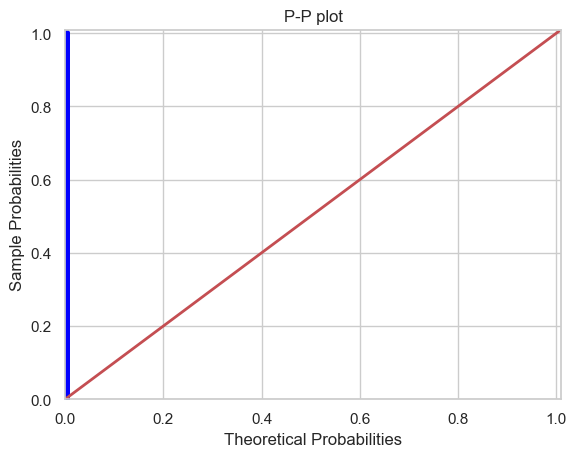


Gráficas para una distribución weibull

Parámetro estimado: Escala = 419.18473261370525
Parámetro estimado: Forma = 0.9901078613529684


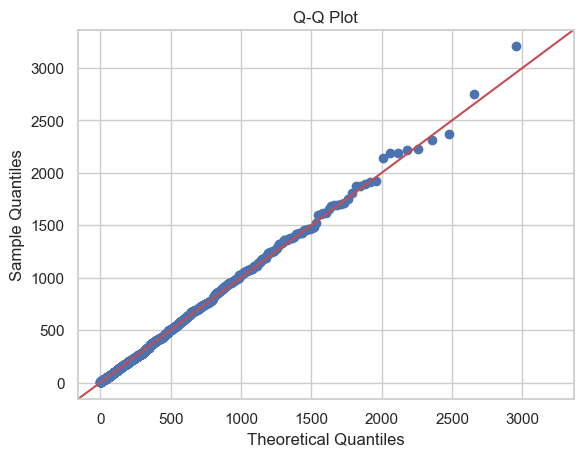

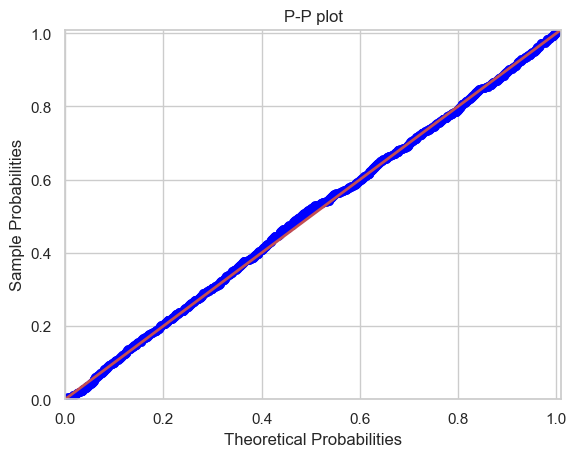


	GRAFICAS PARA Franja_4

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Gráficas para una distribución normal

Parámetro estimado: Media = 655.7521889055472
Parámetro estimado: Desviación Estándar = 139.7745869337093


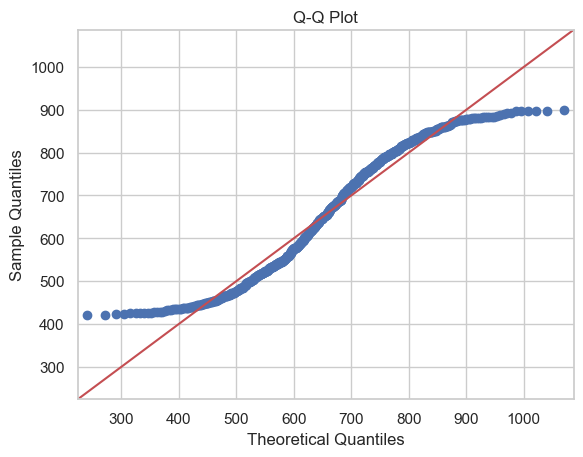

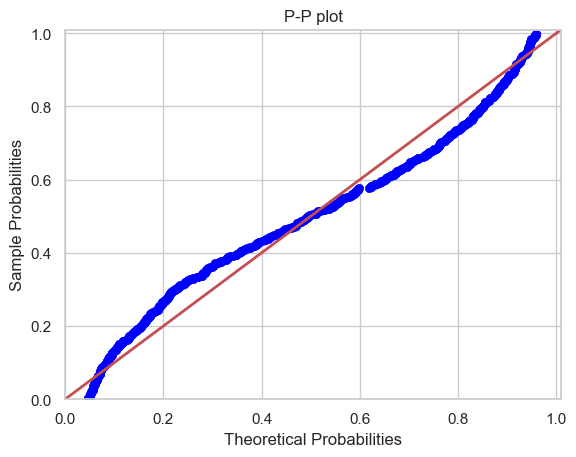


Gráficas para una distribución lognormal

Parámetro estimado (normal asociada): Media = 6.462139396926297
Parámetro estimado (normal asociada): Desviación Estándar = 0.2198768790799957


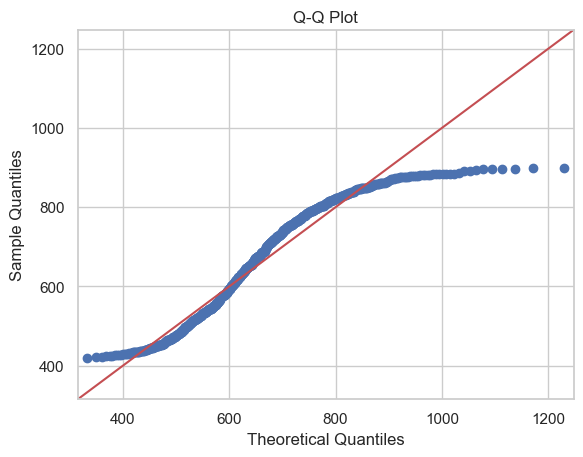

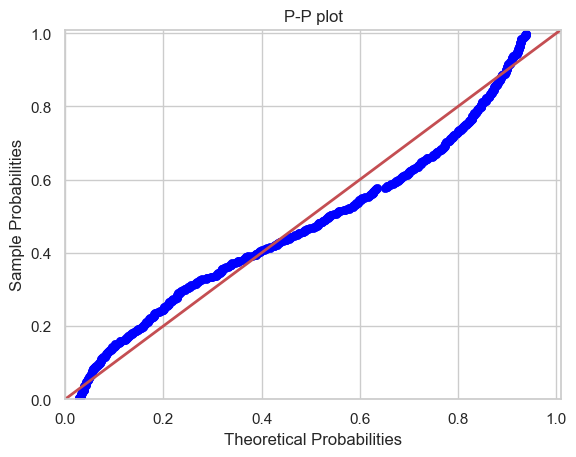


Gráficas para una distribución exponencial

Parámetro estimado: Tasa = 0.0015249663164205423


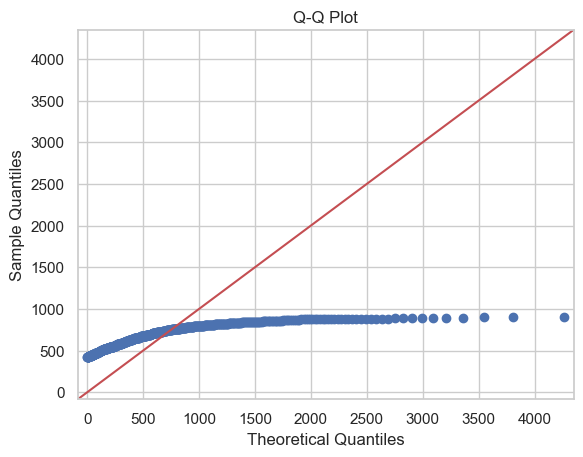

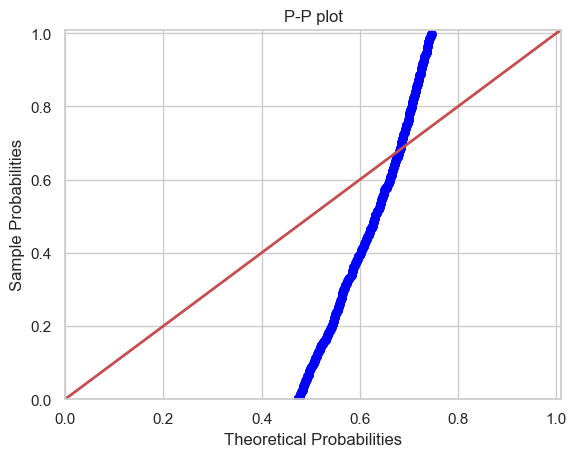


Gráficas para una distribución uniforme

Parámetro estimado: a = 420.614
Parámetro estimado: b = 899.9


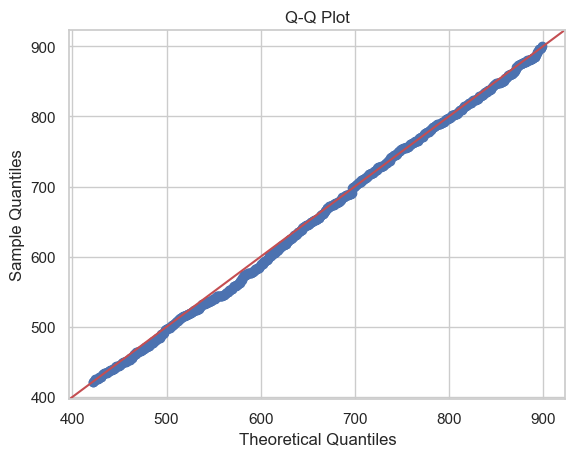

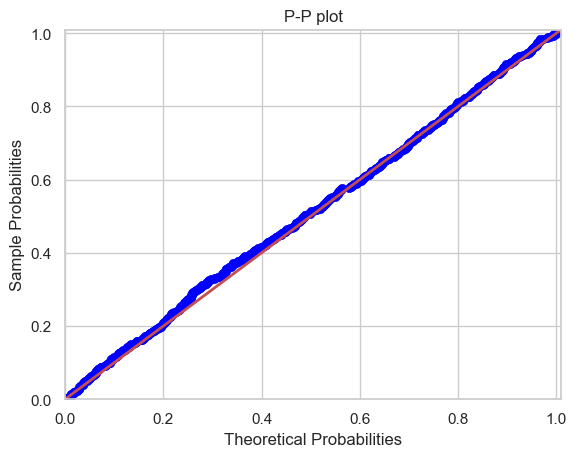


Gráficas para una distribución triangular

Parámetro estimado: a = 420.614
Parámetro estimado: b = 899.9
Parámetro estimado: c = 577.599


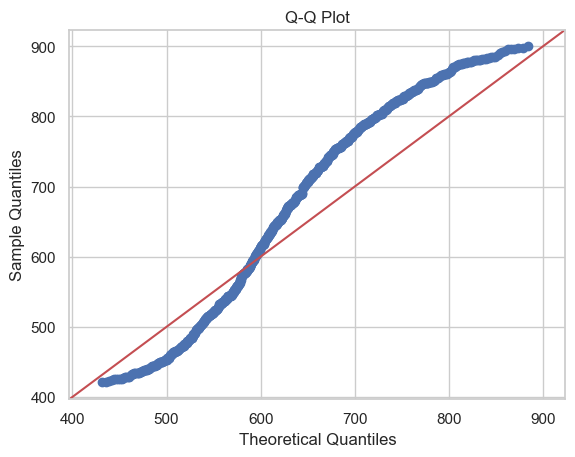

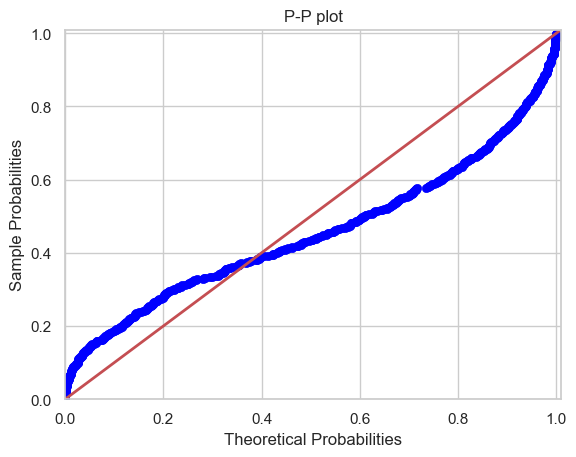


Gráficas para una distribución gamma

Parámetro estimado: Media = 655.7521889055472
Parámetro estimado: Varianza = 19536.93515248905


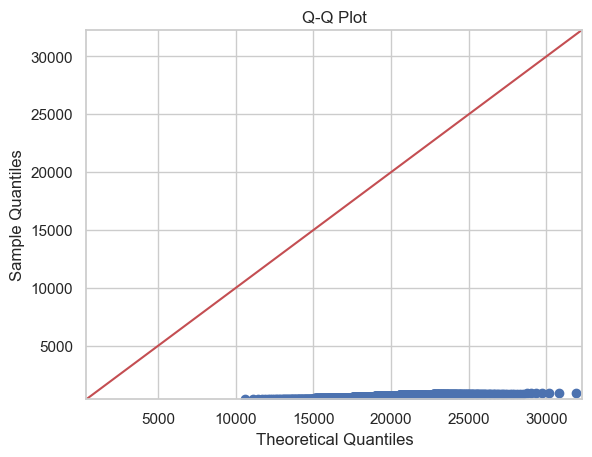

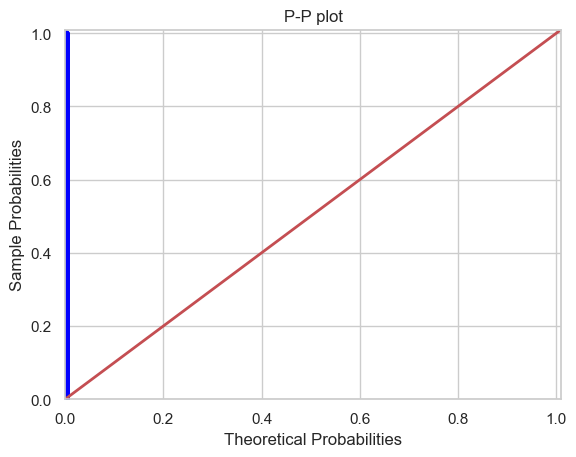


Gráficas para una distribución weibull

Parámetro estimado: Escala = 712.5481650604098
Parámetro estimado: Forma = 5.368939300249638


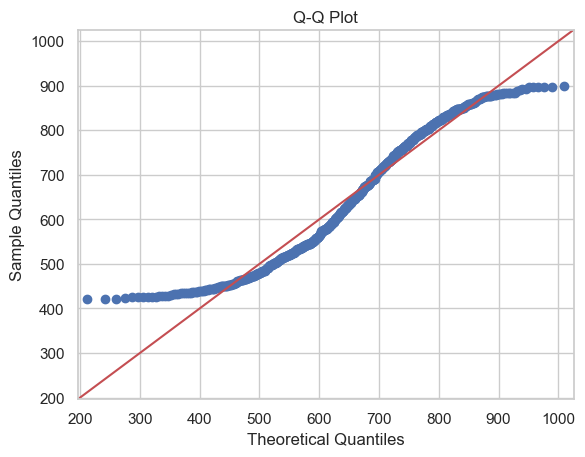

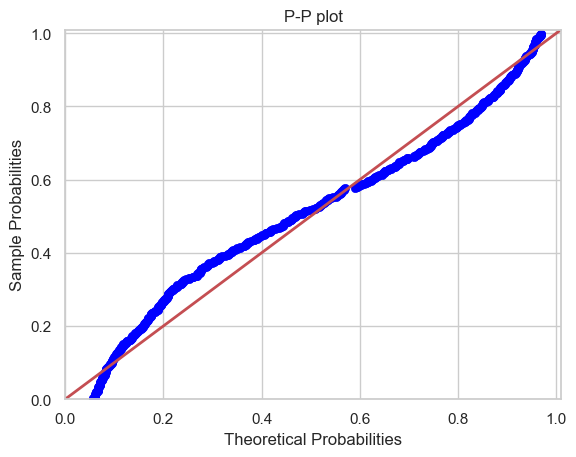

In [4]:
for franja, tiempos in resultados.items():
    resultados_array = tiempos.to_numpy()

    print(f"\n\t\033[1mGRAFICAS PARA {franja}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")



    print("\nGráficas para una distribución normal\n")
    PP_QQ_plot_normal(resultados_array,media="estimado",desvesta="estimado")

    print("\nGráficas para una distribución lognormal\n")
    PP_QQ_plot_lognormal(resultados_array,media="estimado",desvesta="estimado")

    print("\nGráficas para una distribución exponencial\n")
    PP_QQ_plot_exponential(resultados_array,tasa="estimado")

    print("\nGráficas para una distribución uniforme\n")
    PP_QQ_plot_uniform(resultados_array,minimo="estimado",maximo="estimado")

    print("\nGráficas para una distribución triangular\n")
    PP_QQ_plot_triangular(resultados_array,minimo="estimado",maximo="estimado",moda="estimado")

    print("\nGráficas para una distribución gamma\n")
    PP_QQ_plot_gamma(resultados_array,media="estimado",varianza="estimado")

    print("\nGráficas para una distribución weibull\n")
    PP_QQ_plot_weibull(resultados_array,forma="estimado",escala="estimado")

#### Franja 1 y 3
- Las distribuciones normal, lognormal, uniforme, triangular y gamma amplifican los espacios en los extremos (para el QQ Plot) y en el centro (para el PP Plot). Por ende, podemos decir que estas no se acercan a la distribución real de los datos
- Por otro lado, las distribuciones **exponencial y Weibull** siguen la línea con pendiente 0 casi de forma perfecta. Se sugiere usar alguna de estas dos distribuciones.

#### Franja 2
- Las distribuciones exponencial, uniforme, triangular, gamma y Weilbull amplifican los espacios en los extremos (para el QQ Plot) y en el centro (para el PP Plot). Por ende, podemos decir que estas no se acercan a la distribución real de los datos
- Por otro lado, las distribuciones **normal y lognormal** siguen la línea con pendiente 0 casi de forma perfecta. Se sugiere usar alguna de estas dos distribuciones.


#### Franja 4
- Todas las distribuciones menos la uniforme los espacios en los extremos (para el QQ Plot) y en el centro (para el PP Plot). Por ende, podemos decir que estas no se acercan a la distribución real de los datos. Por lo tanto se concluye que podría seguir una **distribución uniforme**.

### Pruebas de bondad de ajuste

Para poder concluir de forma más certera, se decide utilizar pruebas de bondad de ajuste. En este caso vamos a usar la prueba Chi Cuadrado por que se cuenta con una cantidad suficiente de datos.

De esta forma se seguirá el mismo ciclo que el punto anterior pero con los resultados de fir para la prueba de bondad de ajuste Chi cuadrado.

In [5]:
for franja, tiempos in resultados.items():
    resultados_array = tiempos.to_numpy()

    print(f"\n\t\033[1mPRUEBAS DE BONDAD Y AJUSTE PARA {franja}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")
    print(f"\033[31m{'-' * 50}\033[0m\n")



    print("\nPrueba de bondad y ajuste para distribución normal\n")
    chi_square_normal_goodness_of_fit(resultados_array,media="estimado",desvesta="estimado",r=2)

    print("\nPrueba de bondad y ajuste para distribución lognormal\n")
    chi_square_lognormal_goodness_of_fit(resultados_array,media="estimado",desvesta="estimado",r=2)

    print("\nPrueba de bondad y ajuste para distribución exponencial\n")
    chi_square_exponential_goodness_of_fit(resultados_array,tasa="estimado",r=1)

    print("\nPrueba de bondad y ajuste para distribución uniforme\n")
    chi_square_uniform_goodness_of_fit(resultados_array,minimo="estimado",maximo="estimado",r=2)

    print("\nPrueba de bondad y ajuste para distribución triangular\n")
    chi_square_triangular_goodness_of_fit(resultados_array,minimo="estimado",maximo="estimado",moda="estimado",r=3)

    print("\nPrueba de bondad y ajuste para distribución gamma\n")
    chi_square_gamma_goodness_of_fit(resultados_array,media="estimado",varianza="estimado",r=2)

    print("\nPrueba de bondad y ajuste para distribución weibull\n")
    chi_square_weibull_goodness_of_fit(resultados_array,forma="estimado",escala="estimado",r=2)



	PRUEBAS DE BONDAD Y AJUSTE PARA Franja_1

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Prueba de bondad y ajuste para distribución normal

Parámetro estimado: Media = 356.9033648780488
Parámetro estimado: Desviación Estándar = 349.25628560960234
Chi-squared statistic: 857.2000000000031
p-value: 0.0

Prueba de bondad y ajuste para distribución lognormal

Parámetro estimado (lognormal asociada): Media = 5.3225267637146585
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2498301729549852
Chi-squared statistic: 363.6000000000009
p-value: 2.3733348619714434e-11

Prueba de bondad y ajuste para distribución exponencial

Parámetro estimado: Tasa = 0.0028018788792918566
Chi-squared statistic: 169.5999999999993
p-value: 0.9577199926644172

Prueba de bondad y ajuste para distribución uniforme

Parámetro estimado: a = 0.213
Parámetro estimado: b = 2755.953
Chi-squared s

/Users/camilaleniss/Documents/miad/miad-optimizacion/simulacion/week-3/funcioneschicuadrado_continuas.py:350: RuntimeWarning: divide by zero encountered in scalar divide
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2 / expected_frequencies[i] for i in range(k-1))
/Users/camilaleniss/Documents/miad/miad-optimizacion/simulacion/week-3/funcioneschicuadrado_continuas.py:350: RuntimeWarning: invalid value encountered in scalar divide
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2 / expected_frequencies[i] for i in range(k-1))


Chi-squared statistic: 3084.3066883116962
p-value: 0.0

Prueba de bondad y ajuste para distribución triangular

Parámetro estimado: a = 1.069
Parámetro estimado: b = 3204.63
Parámetro estimado: c = 269.152
Chi-squared statistic: 8593.317546572103
p-value: 0.0

Prueba de bondad y ajuste para distribución gamma

Parámetro estimado: Media = 421.00287912087913
Parámetro estimado: Varianza = 183017.91175069168
Chi-squared statistic: nan
p-value: nan

Prueba de bondad y ajuste para distribución weibull

Parámetro estimado: Escala = 419.18473261370525
Parámetro estimado: Forma = 0.9901078613529684
Chi-squared statistic: 218.7746881018935
p-value: 0.1373523522590664

	PRUEBAS DE BONDAD Y AJUSTE PARA Franja_4

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------


Prueba de bondad y ajuste para distribución normal

Parámetro estimado: Media = 655.7521889055472
Parámetro estimado: Desviación Est

#### Conclusiones

##### **Franja 1**

Las distribuciones que habíamos descartado anteriormente volvieron a ser descartadas por tener valores de p-value muy pequeños. Habíamos quedado entre la distribución exponencial y Weibull. Se obtuvieron los siguientes resultados:

- Prueba de bondad y ajuste para distribución exponencial
  - Parámetro estimado: Tasa = 0.0028018788792918566
  - Chi-squared statistic: 169.5999999999993
  - p-value: 0.9577199926644172

- Prueba de bondad y ajuste para distribución weibull
  - Parámetro estimado: Escala = 360.11129894444923
  - Parámetro estimado: Forma = 1.0219414569820682
  - Chi-squared statistic: 234.78670944243387
  - p-value: 0.05668670821004207

Se decide quedarse con la **distribución exponencia**l puesto que su valor de p-value es mayor.

##### **Franja 2**

Las distribuciones que habíamos descartado anteriormente volvieron a ser descartadas por tener valores de p-value muy pequeños. Habíamos quedado entre la distribución normal y lognormal. Se obtuvieron los siguientes resultados:

- Prueba de bondad y ajuste para distribución normal
  - Parámetro estimado: Media = 221.5082436908517
  - Parámetro estimado: Desviación Estándar = 22.929183141009595
  - Chi-squared statistic: 273.1734735227811
  - p-value: 0.15020570366839303

- Prueba de bondad y ajuste para distribución lognormal
  - Parámetro estimado (lognormal asociada): Media = 5.3951237339450016
  - Parámetro estimado (lognormal asociada): Desviación Estándar = 0.1033441222569458
  - Chi-squared statistic: 241.61987381703034
  - p-value: 0.6365071177875545

Se decide quedarse con la **distribución lognormal**l puesto que su valor de p-value es mayor.

##### **Franja 3**

Las distribuciones que habíamos descartado anteriormente volvieron a ser descartadas por tener valores de p-value muy pequeños. Habíamos quedado entre la distribución exponencial y Weibull. Se obtuvieron los siguientes resultados:

- Prueba de bondad y ajuste para distribución exponencial
  - Chi-squared statistic: 176.62037462537424
  - p-value: 0.8603403458156594

- Prueba de bondad y ajuste para distribución weibull
  - Parámetro estimado: Escala = 419.18473261370525
  - Parámetro estimado: Forma = 0.9901078613529684
  - Chi-squared statistic: 218.7746881018935
  - p-value: 0.1373523522590664

Se decide quedarse con la **distribución exponencia**l puesto que su valor de p-value es mayor.

##### Franja 4

Las distribuciones que habíamos descartado anteriormente volvieron a ser descartadas por tener valores de p-value muy pequeños. Esto nos deja solamente con la **distribución uniforme** que tiene un valor grande de p-value, lo que nos hace validar que se sigue esta distribución.

- Prueba de bondad y ajuste para distribución uniforme
  - Parámetro estimado: a = 420.614
  - Parámetro estimado: b = 899.9
  - Chi-squared statistic: 137.5801648048167
  - p-value: 0.30768372682002554

## Distribución de tiempo de atención del módulo biométrico inteligente

Para estos datos se utilizará la hoja de TiempoDeServicioBiométrico, donde cada fila representa el dato de una persona atendida, detallando el tipo de pasaporte y el tiempo en el servicio biométrico en minutos.

In [6]:
# Cargar el archivo de Excel
datos_servicio_biometrico = pd.read_excel(archivo_excel, sheet_name='TiempoDeServicioBiométrico')
datos_servicio_biometrico.head(4)

,Persona atendida,Tipo de pasaporte,Tiempo de servicio (minutos)
0,1,Biométrico,0.349995
1,2,Biométrico,2.046627
2,3,Biométrico,0.232612
3,4,Biométrico,1.085411


### Distribuciones según histogramas

Se procede a graficar un histograma para tener un primer acercamiento a la distribución que siguen los datos.

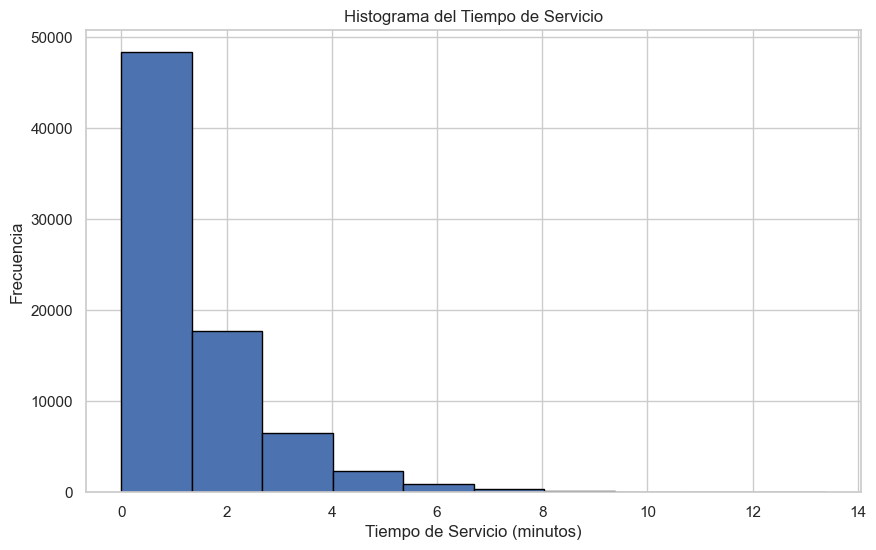

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(datos_servicio_biometrico['Tiempo de servicio (minutos)'], bins=10, edgecolor='black')

# Añadir títulos y etiquetas
plt.title('Histograma del Tiempo de Servicio')
plt.xlabel('Tiempo de Servicio (minutos)')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.grid(True)
plt.show()

Segun la gráfica presentada, podríamos esperar una distribución exponencial o Weibull. Esto de acuerdo a lo que observamos en el punto anterior para distribuciones similares.

### Gráficas Q-Q y P-P Plot

Ahora se van a realizar gráficas Q-Q Plot y P-P Plot para todas las distribuciones que conocemos y tener un mejor acercamiento a la distribución que sigue


Gráficas para una distribución normal

Parámetro estimado: Media = 1.3350003637764654
Parámetro estimado: Desviación Estándar = 1.329438449470138


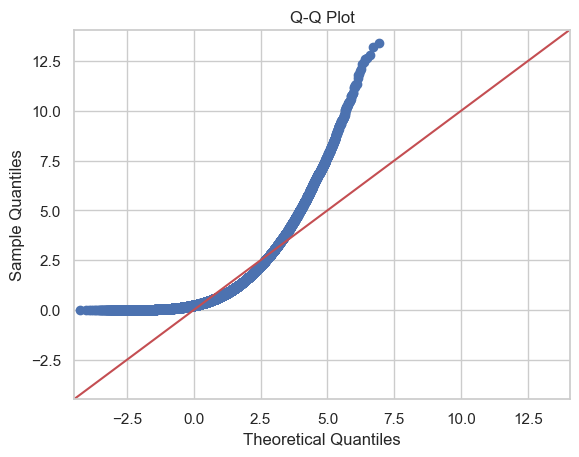

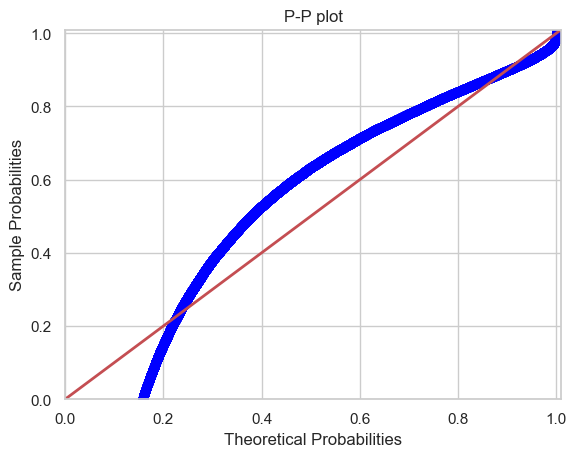


Gráficas para una distribución lognormal

Parámetro estimado (normal asociada): Media = -0.28596756733168804
Parámetro estimado (normal asociada): Desviación Estándar = 1.2803043893885682


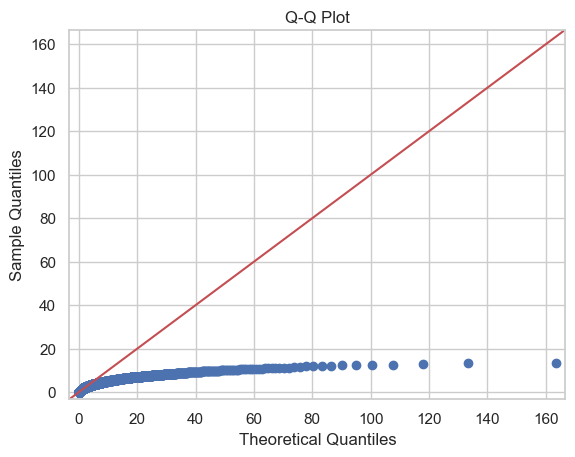

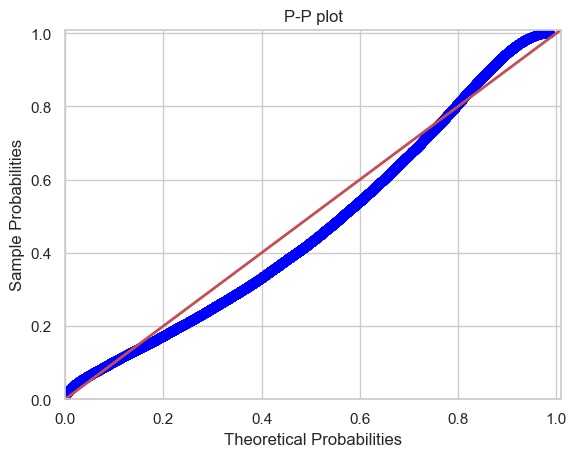


Gráficas para una distribución exponencial

Parámetro estimado: Tasa = 0.7490634662983819


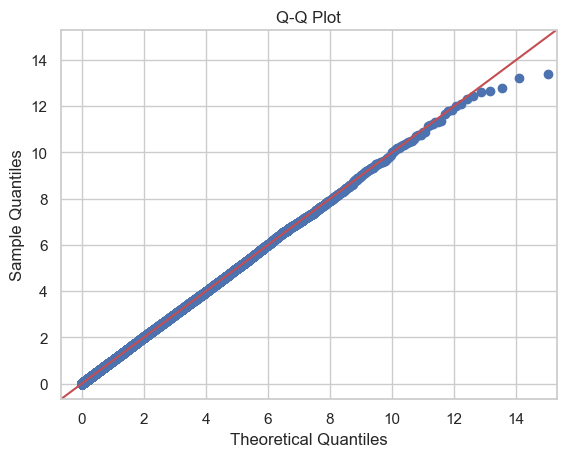

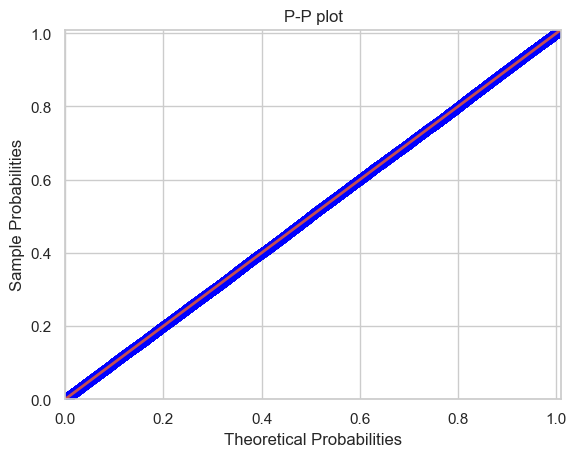


Gráficas para una distribución uniforme

Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463


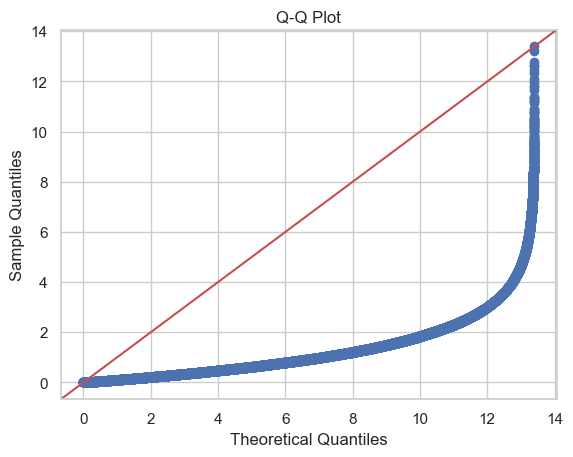

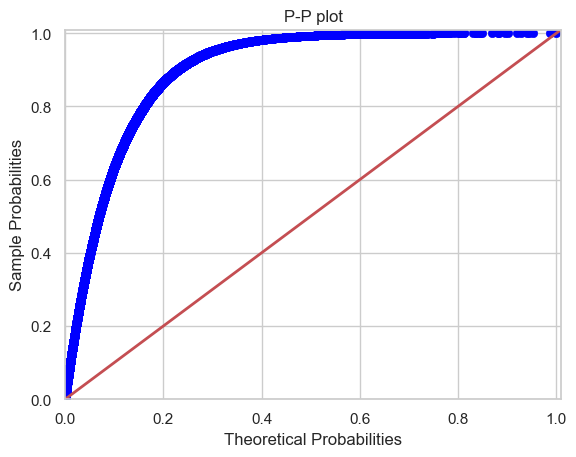


Gráficas para una distribución triangular

Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463
Parámetro estimado: c = 0.34999512395856236


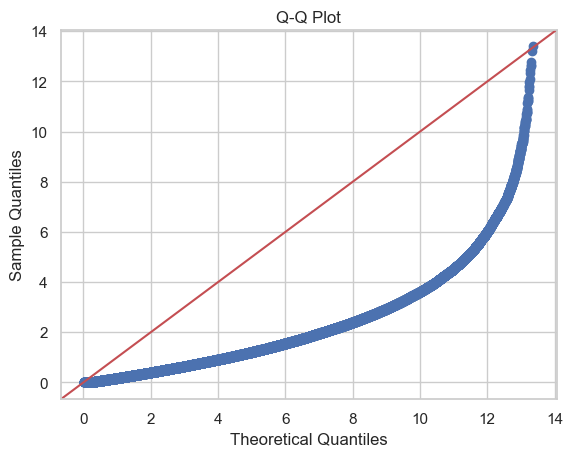

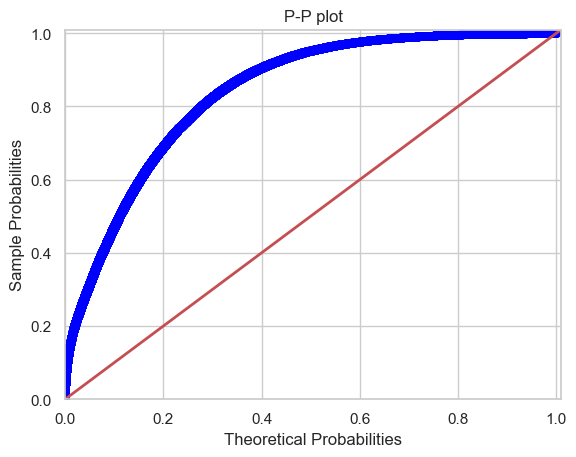


Gráficas para una distribución gamma

Parámetro estimado: Media = 1.3350003637764654
Parámetro estimado: Varianza = 1.7674065909295642


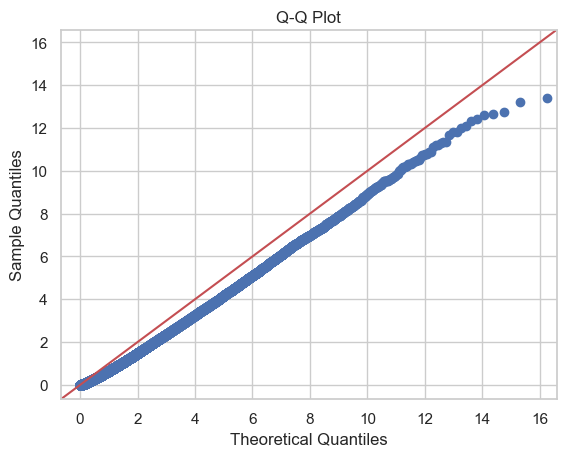

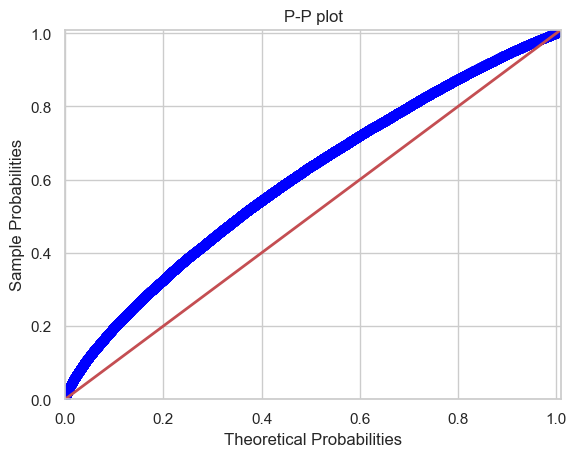


Gráficas para una distribución weibull

Parámetro estimado: Escala = 1.3365523718394834
Parámetro estimado: Forma = 1.0027390493416182


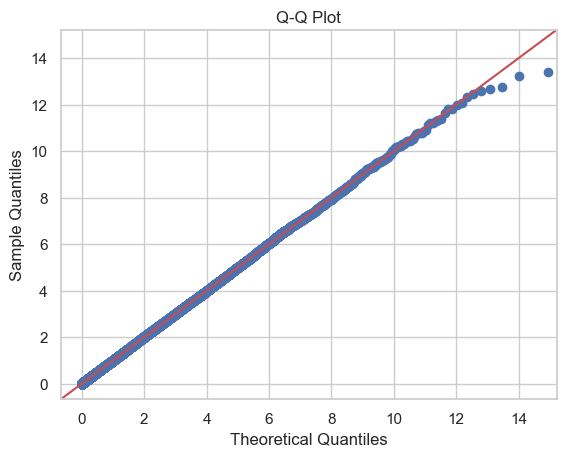

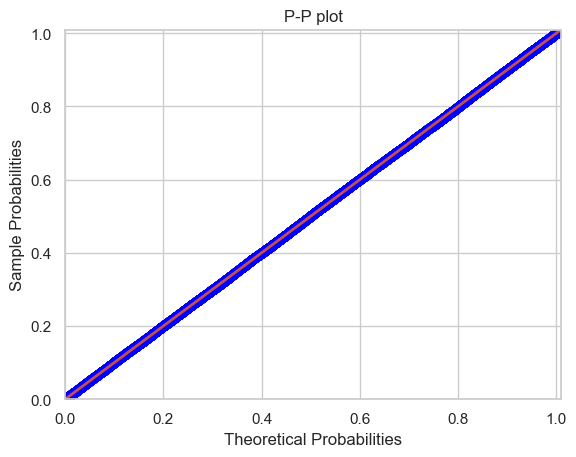

In [8]:
datos_servicio_biometrico
resultados_array = datos_servicio_biometrico["Tiempo de servicio (minutos)"].to_numpy()


print("\nGráficas para una distribución normal\n")
PP_QQ_plot_normal(resultados_array,media="estimado",desvesta="estimado")

print("\nGráficas para una distribución lognormal\n")
PP_QQ_plot_lognormal(resultados_array,media="estimado",desvesta="estimado")

print("\nGráficas para una distribución exponencial\n")
PP_QQ_plot_exponential(resultados_array,tasa="estimado")

print("\nGráficas para una distribución uniforme\n")
PP_QQ_plot_uniform(resultados_array,minimo="estimado",maximo="estimado")

print("\nGráficas para una distribución triangular\n")
PP_QQ_plot_triangular(resultados_array,minimo="estimado",maximo="estimado",moda="estimado")

print("\nGráficas para una distribución gamma\n")
PP_QQ_plot_gamma(resultados_array,media="estimado",varianza="estimado")

print("\nGráficas para una distribución weibull\n")
PP_QQ_plot_weibull(resultados_array,forma="estimado",escala="estimado")

En este caso vemos que nuestras sospechas parecen ser ciertas. Para las distribuciones normal, lognormal, unifroma, triangular y gamma se amplifican las diferencias en el centro o en lo extremos según sea el gráfico.

Sin embargo, para las distribuciones **exponencial y Weibull** se sigue casa perfectamente la línea con pendiente igual 1. Por lo que se sugiere utilizar alguna de esas dos distribuciiones.

### Distribución según las Pruebas de bondad de ajuste

Con el fin de validar matemáticamente lo encontrado en el punto anterior se va a calcular las pruebas de bondad de ajuste. En este caso utilizaremos la prueba Chi Cuadrado puesto que contamos con suficientes datos para utilizar esta técnica.

In [9]:
print("\nPrueba de bondad y ajuste para distribución normal\n")
chi_square_normal_goodness_of_fit(resultados_array,media="estimado",desvesta="estimado",r=2)

print("\nPrueba de bondad y ajuste para distribución lognormal\n")
chi_square_lognormal_goodness_of_fit(resultados_array,media="estimado",desvesta="estimado",r=2)

print("\nPrueba de bondad y ajuste para distribución exponencial\n")
chi_square_exponential_goodness_of_fit(resultados_array,tasa="estimado",r=1)

print("\nPrueba de bondad y ajuste para distribución uniforme\n")
chi_square_uniform_goodness_of_fit(resultados_array,minimo="estimado",maximo="estimado",r=2)

print("\nPrueba de bondad y ajuste para distribución triangular\n")
chi_square_triangular_goodness_of_fit(resultados_array,minimo="estimado",maximo="estimado",moda="estimado",r=3)

print("\nPrueba de bondad y ajuste para distribución gamma\n")
chi_square_gamma_goodness_of_fit(resultados_array,media="estimado",varianza="estimado",r=2)

print("\nPrueba de bondad y ajuste para distribución weibull\n")
chi_square_weibull_goodness_of_fit(resultados_array,forma="estimado",escala="estimado",r=2)


Prueba de bondad y ajuste para distribución normal

Parámetro estimado: Media = 1.3350003637764654
Parámetro estimado: Desviación Estándar = 1.329438449470138
Chi-squared statistic: 75555.87492617394
p-value: 0.0

Prueba de bondad y ajuste para distribución lognormal

Parámetro estimado (lognormal asociada): Media = -0.28596756733168804
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2803043893885682
Chi-squared statistic: 46497.16928467163
p-value: 0.0

Prueba de bondad y ajuste para distribución exponencial

Parámetro estimado: Tasa = 0.7490634662983819
Chi-squared statistic: 15398.19341757483
p-value: 0.17924519457109467

Prueba de bondad y ajuste para distribución uniforme

Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463
Chi-squared statistic: 320906.36545804405
p-value: 0.0

Prueba de bondad y ajuste para distribución triangular

Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463
Parám

/Users/camilaleniss/Documents/miad/miad-optimizacion/simulacion/week-3/funcioneschicuadrado_continuas.py:350: RuntimeWarning: invalid value encountered in scalar divide
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2 / expected_frequencies[i] for i in range(k-1))


#### Conclusiones

Como pudimos ver en puntos anteriores, los estadísticos para las distribuciones normal, lognormal, uniforme, triangular y gamma nos dicen que no se sigue alguna de estas distribuciones. Su p-value es muy pequeño.

Habíamos dicho que podría ser una distribución exponencial o Weibull, obteniendo los siguientes resultados

- Prueba de bondad y ajuste para distribución exponencial
  - Parámetro estimado: Tasa = 0.7490634662983819
  - Chi-squared statistic: 15398.19341757483
  - p-value: 0.17924519457109467

- Prueba de bondad y ajuste para distribución weibull
  - Parámetro estimado: Escala = 1.3365523718394834
  - Parámetro estimado: Forma = 1.0027390493416182
  - Chi-squared statistic: 16116.963196923843
  - p-value: 3.697171411243261e-07

El valor del estadístico de Chi cuadrado para la función exponencial es menor que para la distribución Weilbull, pero el valor de p-value es muy pequeño para la distribución de Weibull. Por ende **se decide quedarse con la distribución exponencial para caracterizar el tiempo en el servicio biométrico**.

## Probabilidad de que el avión que acaba de aterrizar sea grande, mediano o pequeño

Ahora, vamos a calcular el número de datos por tipo de avión para así poder calcular la probabilidad de que el avión que acaba de aterrizar sea de cada tipo.

In [10]:
# Contar los aterrizajes por tipo de avión
cuenta_por_tipo = datos_llegada_aviones['Tipo de Avión'].value_counts()

cuenta_por_tipo

Tipo de Avión
Mediano    2623
Grande     1314
Pequeño     437
Name: count, dtype: int64

In [11]:
# Calcular la probabilidad de cada tipo
probabilidad_por_tipo = cuenta_por_tipo / len(datos_llegada_aviones)

print("Probabilidad de que el avión sea grande, mediano o pequeño:")
print(probabilidad_por_tipo)

Probabilidad de que el avión sea grande, mediano o pequeño:
Tipo de Avión
Mediano    0.599680
Grande     0.300412
Pequeño    0.099909
Name: count, dtype: float64


- La probabilidad de que el avión que acaba de aterrizar sea grande es del 30%
- La probabilidad de que el avión que acaba de aterrizar sea mediano es del 60% aproximamente
- La probabilidad de que el avión que acaba de aterrizar sea pequeño es del 10% aproximadamente

## Probabilidad asociada al tipo de pasajero/pasaporte

Ahora, vamos a calcular el número de datos por tipo de pasaporte para así poder calcular la probabilidad de que una persona tenga cada tipo de pasaporte

In [12]:
# Cargar el archivo de Excel
datos_pasajeros = pd.read_excel(archivo_excel, sheet_name='DatosPasajeros')
datos_pasajeros.head(4)

,Pasajero,Tipo de pasaporte,¿Lleva maleta?
0,1,Extranjero,Sí
1,2,Nacional no biométrico,No
2,3,Nacional no biométrico,Sí
3,4,Nacional no biométrico,Sí


In [13]:
cuenta_por_tipo_pasaporte = datos_pasajeros['Tipo de pasaporte'].value_counts()

cuenta_por_tipo_pasaporte

Tipo de pasaporte
Extranjero                279638
Nacional no biométrico    151689
Nacional biométrico        76203
Name: count, dtype: int64

In [14]:
# Calcular la probabilidad de cada tipo
probabilidad_por_tipo = cuenta_por_tipo_pasaporte / len(datos_pasajeros)

print("Probabilidad de cada tipo de pasaporte:")
print(probabilidad_por_tipo)

Probabilidad de cada tipo de pasaporte:
Tipo de pasaporte
Extranjero                0.550978
Nacional no biométrico    0.298877
Nacional biométrico       0.150145
Name: count, dtype: float64


- La probabilidad de que una persona tenga pasaporte Extranjero es del 55%
- La probabilidad de que una persona tenga pasaporte no biométrico es del 30% aproximadamente
- La probabilidad de que una persona tenga pasaporte. biométrico es del 15% aproximadamente

## Probabilidad de que el pasajero haya viajado con maleta

Ahora, vamos a calcular el número de datos de cada pasajero para saber qué tan probable es que haya viajado o no con maleta

In [15]:
cuenta_maleta = datos_pasajeros['¿Lleva maleta?'].value_counts()

cuenta_maleta

¿Lleva maleta?
Sí    372153
No    135377
Name: count, dtype: int64

In [16]:
# Calcular la probabilidad de si llevaría o no maleta
prob_maleta = cuenta_maleta / len(datos_pasajeros)

print("Probabilidad de si el pasajero llevaría maleta:")
print(prob_maleta)

Probabilidad de si el pasajero llevaría maleta:
¿Lleva maleta?
Sí    0.733263
No    0.266737
Name: count, dtype: float64


- La probabilidad de que el pasajero haya viajado con maleta es del 73.3%
- La probabilidad de que el pasajero haya viajado sin maleta es del 26.6%